# Project structure

This project consists of a comparison between the DBN (using three hidden layers) and FFNN models. The approach followed will be the same as the one used in our labs. The dataset chosen is Fashion MNIST. In order to get started, it is necessary to import the implementation of DBN in PyTorch along with the required libraries for the implementation. The next step is to download our dataset and split it into a training and testing set in order to evaluate our network. Once the preliminary steps are fulfilled, it is time to train the DBN and visualize the learned weights of each hidden layer. applying linear decoding to our hidden representation to classify the data and calculate the performance of our network. Train a feed-forward NN to our data, with structure and parameters the same as those used on DBN, in order to compare two models. In the last part, we will check the robustness to noise by adding Gaussian noise and applying adversarial attacks. The performance of both models will be explored by plotting psychometric curves against noise level and attack strength, respectively. In the appendix, I added one of experiments done by chaniging the parameters of the DBN architecture.


# Import libraries / prepare our data

In [33]:
# import python files

def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}


In [31]:
%%capture
get_dbn_library()

In [1]:
# import libraries

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from tqdm.notebook import tqdm
import torch.nn.functional as functional



from DBN import DBN



In [2]:
# use GPU if it is available for the computation otherwise CPU

print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


False


Below we will download our dataset. Instead of numbres in this dataset we find images of Zalando's clothes. As classifying seems to be more complex, the number of observations/ classes is the same as in the dataset used in labs.

In [3]:
                                                                                                                                                                                        %%capture

# download train and test set 

fashion_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()] # transform each image in a multi-dimensional array that can be used as input by neural network
                                         ))                                   

fashion_test = tv.datasets.FashionMNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [4]:
# scale the input between 0 and 1

fashion_train.data = (fashion_train.data.type(torch.FloatTensor)/255)
fashion_test.data = (fashion_test.data.type(torch.FloatTensor)/255)

In [5]:
# move data to GPU to accelerate computations

fashion_train.data = fashion_train.data.to(device)
fashion_train.data = fashion_train.data.to(device)

# do the same with the target classification of data

fashion_train.targets = fashion_train.targets.to(device)
fashion_train.targets = fashion_train.targets.to(device)


# DBN

In this step we will train our DBN. As we did in the lab, this model is trained using contrantive divergence algorithms, which improves feature representation by capturing the high-level structure of the data rather than just memorizing some specific examples, reduces the difference between the learned probability disribution and the true one. 

In [6]:
# define DBN
# nr of pixels in each image: 28 * 28 = 784
# 3 hidden layers with 400, 500, 800 units respectively
# contrastive divergence , k =1

dbn_fashion = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1, 
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Looking at the statistics provided below we can say that:


1.   Reconstruction errors decrease over time as the RBM layers are trained. This means that the network is learning to capture the underlying data structure.
2.   Mean gradients seem to be decreasing over time, which suggests that RBMs are converging to a good set of parameters.



In [7]:
# train the network 

num_epochs = 50
batch_size = 125

dbn_fashion.train_static(
    fashion_train.data,
    fashion_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8710     |0.0846       |313.0433   |7.0572     |
|20    |1.7511     |0.0795       |297.6728   |4.6555     |
|30    |1.7180     |0.0788       |294.8996   |6.0773     |
|40    |1.7043     |0.0786       |292.0572   |5.3806     |
|50    |1.6953     |0.0778       |290.8399   |5.2871     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0722     |0.0403       |140.1994   |3.3353     |
|20    |0.9912     |0.0343       |129.2674   |2.0318     |
|30    |0.9698     |0.0329       |125.9605   |1.9378     |
|40    |0.9626     |0.0332       |124.3426   |2.1268     |
|50    |0.9547     |0.0327       |122.8871   |2.0803     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8342     |0.0262       |148.1409   |2.2586     |
|20    |0.7334     |0.0234       |135.1617   |2.220

To understand better what kind of features the model is learning at each layer we can visualize the receptive fields. Applying a threshold to the learned weights, standardizing different ranges of weights using MinMaxScalar, will allow us to make plots less noisy and compare different receptive fields more easily.



In [8]:
def get_weights(dbn, layer):
    return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
    num_subplots = 100 #change the number if we want to increase the receptive field
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
    original_shape = learned_weights.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
    min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
    return min_max_scaled_learned_weights  

Plotting the receptive field of layer one, we can clearly see that is trying to catch edges, corners of images so it is learning local features that are important to recognize the input.

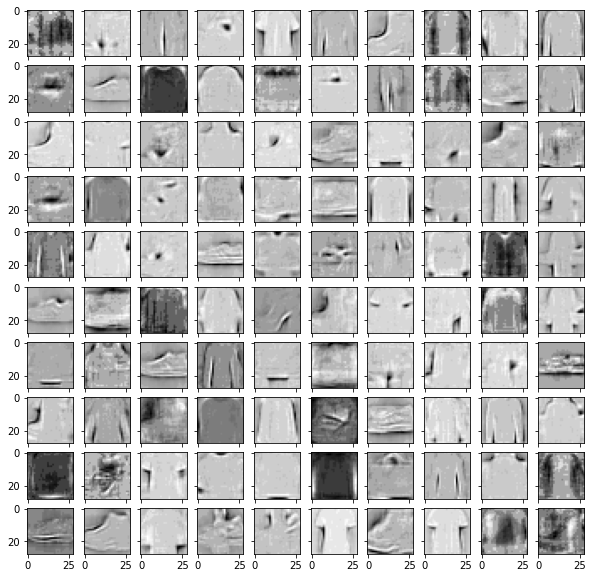

In [9]:
# plotting what the first hidden layer is learning

learned_weights_layer_1 = get_weights(dbn_fashion, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

Plotting what the second and third hidden layer has learned, as we move forward we cna see that the model is trying to capture more abstract and higher-level feature of the input.

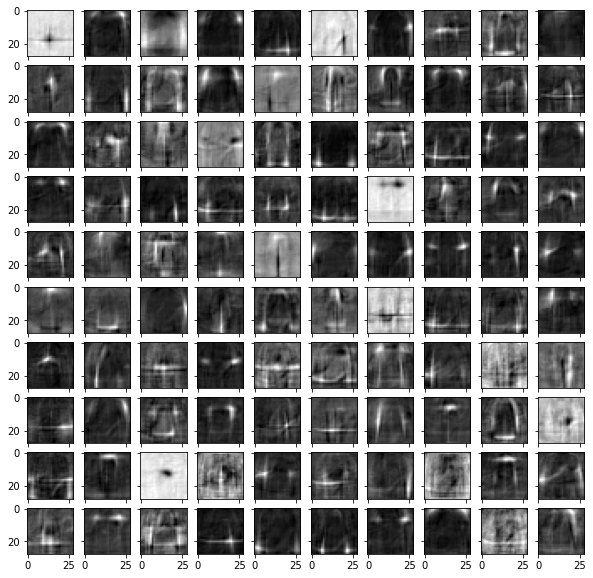

In [10]:
# plotting what the second hidden layer is learning

learned_weights_layer_1 = get_weights(dbn_fashion, layer=0)
learned_weights_layer_2 = get_weights(dbn_fashion, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

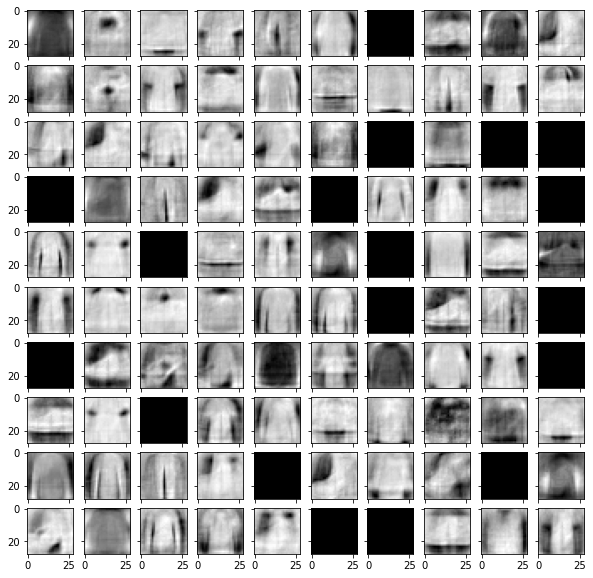

In [11]:
# plotting what the third hidden layer is learning

learned_weights_layer_1 = get_weights(dbn_fashion, layer=0)
learned_weights_layer_2 = get_weights(dbn_fashion, layer=1)
learned_weights_layer_3 = get_weights(dbn_fashion, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)


To give explicit labels for the input data, using features learned in an unsupervised manner by DBN, we can propagate the neuron's activations from the visible layer to the hidden layers in a bottom-up fashion. We start with the raw input data and use wights of the network to compute the activations of the hidden neurons. This process continous until we reach the final hidden layer. Once we have the hidden represenation, we can train a linear classifier on top of the hidden represantations, using labeled data to learn how to map the hidden representations to the corresponding labels. In the following block of codes, used during labs, we will explorer this idea. The main point is to see how good is the first hidden layer in the overall described process.

In [12]:
#get the hidden layer activation of the GBM

def get_kth_layer_repr(input, k, device):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
    hidden_repr, __ = dbn_fashion.rbm_layers[k].to_hidden(flattened_input)
    return hidden_repr


In [13]:
# the representations of the next layers are computed using the ones of the previous layer

hidden_repr_layer_1 = get_kth_layer_repr(fashion_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [16]:
# linear model class

class LinearModel(torch.nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(layer_size, 10)

    def forward(self, x):
        return self.linear(x)

In [17]:
# create instances of linear model for every layer of the DBN

layer_size = dbn_fashion.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fashion.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [18]:
# function to train linear classifier

def train(network, hidden_reprs):
    optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
    loss_fn = torch.nn.CrossEntropyLoss()
    epochs = 1500

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = network(hidden_reprs).squeeze()
        targets = fashion_train.targets.reshape(predictions.shape[0])
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

Training the first layer, we see that after each epoch the loss have a decreasing trend. 

In [19]:
train(linear1, hidden_repr_layer_1)

epoch :   1/1500, loss = 2.3367
epoch : 101/1500, loss = 0.9378
epoch : 201/1500, loss = 0.7319
epoch : 301/1500, loss = 0.6494
epoch : 401/1500, loss = 0.6023
epoch : 501/1500, loss = 0.5706
epoch : 601/1500, loss = 0.5473
epoch : 701/1500, loss = 0.5291
epoch : 801/1500, loss = 0.5145
epoch : 901/1500, loss = 0.5024
epoch : 1001/1500, loss = 0.4921
epoch : 1101/1500, loss = 0.4832
epoch : 1201/1500, loss = 0.4755
epoch : 1301/1500, loss = 0.4686
epoch : 1401/1500, loss = 0.4625


The loss of the second layer, start with almost the same value as in the first one but the decrease have a higher band in the second epoch than in the first one.

In [20]:
train(linear2, hidden_repr_layer_2)

epoch :   1/1500, loss = 2.3279
epoch : 101/1500, loss = 0.8051
epoch : 201/1500, loss = 0.6541
epoch : 301/1500, loss = 0.5921
epoch : 401/1500, loss = 0.5554
epoch : 501/1500, loss = 0.5302
epoch : 601/1500, loss = 0.5115
epoch : 701/1500, loss = 0.4969
epoch : 801/1500, loss = 0.4851
epoch : 901/1500, loss = 0.4753
epoch : 1001/1500, loss = 0.4669
epoch : 1101/1500, loss = 0.4598
epoch : 1201/1500, loss = 0.4535
epoch : 1301/1500, loss = 0.4480
epoch : 1401/1500, loss = 0.4431


At this point, I was expecting to obtain lower loss value in the third layer. As shown below, it is clear that the loss is lower in the second layer.

In [21]:
train(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 2.2867
epoch : 101/1500, loss = 0.8601
epoch : 201/1500, loss = 0.6821
epoch : 301/1500, loss = 0.6109
epoch : 401/1500, loss = 0.5701
epoch : 501/1500, loss = 0.5426
epoch : 601/1500, loss = 0.5224
epoch : 701/1500, loss = 0.5068
epoch : 801/1500, loss = 0.4942
epoch : 901/1500, loss = 0.4839
epoch : 1001/1500, loss = 0.4751
epoch : 1101/1500, loss = 0.4676
epoch : 1201/1500, loss = 0.4610
epoch : 1301/1500, loss = 0.4552
epoch : 1401/1500, loss = 0.4501


In the following block of codes we are going to make predictions on test set and evaluate the performance of DBN.

In [22]:
# layer represenation of test data

hidden_repr_layer_1_test = get_kth_layer_repr(fashion_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [23]:
# compute prediction

predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [24]:
# compute accuracy function

def compute_accuracy(predictions_test, targets):
    predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices, what is the class with the highest probability
    accuracy = (predictions_indices == targets).sum() / len(targets)
    return accuracy.item()

From the results of the accuracy, we can notice that it sligltly increases going from first to the second layer. We obtain almost the same value for the first and third layer.

In [25]:
# compute accuracy 

print('Accuracy of first hidden layer {}'.format(compute_accuracy(predictions_test1, fashion_test.targets)))
print('Accuracy of second hidden layer {}'.format(compute_accuracy(predictions_test2, fashion_test.targets)))
print('Accuracy of third hidden layer {}'.format(compute_accuracy(predictions_test3, fashion_test.targets)))


Accuracy of first hidden layer 0.8353999853134155
Accuracy of second hidden layer 0.8396999835968018
Accuracy of third hidden layer 0.8360999822616577


# Feed-forward model

In this section we will train a simple feed-forward neural network, known as multi-layer perceptron, with the same structure of the DBN. The connections between the layers are unidirectional, the learning process is achieved through backpropagation, a type of gradient descent algorithm which tried to minimize the error between true and predicted value.

In [26]:
# ReLU activation function between each hidden layer
# output layer maps the final hidden layer's representation to the 10 possible classes
# input of the model is a tensor with 784 features

class Feedforward(torch.nn.Module):
    def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
        super().__init__()
        self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
        self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
        self.output = torch.nn.Linear(third_hidden_layer_size, 10) 

    def forward(self, input):
        relu = torch.nn.ReLU()
        first_hidden_repr = relu(self.first_hidden(input))
        second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
        third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
        output = self.output(third_hidden_repr)
        return output

Our goal is to compare these two techniques. So, we need to choose the same structure for feed-forward model as the one we choose for DBN. Regarding accuracy: we obtain almost the same value as for DBN, to be precise Feed-forward tends to make 1% more errors than DBN.

In [27]:
# apply the model

ffnn = Feedforward(400, 500, 800).to(device)

# train the model

train(ffnn, fashion_train.data.reshape((60000, 784)))

# make prediction

predictions_ffnn = ffnn(fashion_test.data.reshape((10000, 784)))


# compute accuracy


print('Accuracy we obtain by applying Feed-forward NN to our data: {}'.format(compute_accuracy(predictions_ffnn, fashion_test.targets)))

epoch :   1/1500, loss = 2.2998
epoch : 101/1500, loss = 1.3584
epoch : 201/1500, loss = 0.9096
epoch : 301/1500, loss = 0.7675
epoch : 401/1500, loss = 0.6827
epoch : 501/1500, loss = 0.6207
epoch : 601/1500, loss = 0.5783
epoch : 701/1500, loss = 0.5449
epoch : 801/1500, loss = 0.5238
epoch : 901/1500, loss = 0.5000
epoch : 1001/1500, loss = 0.4876
epoch : 1101/1500, loss = 0.4783
epoch : 1201/1500, loss = 0.4591
epoch : 1301/1500, loss = 0.4518
epoch : 1401/1500, loss = 0.4475
Accuracy we obtain by applying Feed-forward NN to our data: 0.8267999887466431


# Robustness to noise

Below we will try to add some noise to our data and see the performance of DBN and Feed-forward network. The function used during lab, adds Gaussian noise to image data.

In [28]:
def inject_noise(mnist_data, noise_level):
    random_gaussian_tensor = torch.randn(mnist_data.shape, device = device)*noise_level
    return mnist_data + random_gaussian_tensor

Let's see how the image looks like after applying a noise level of 0.3

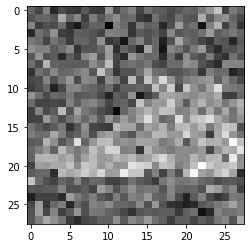

In [30]:
noise_level = 0.3
fashion_test_with_noise = inject_noise(fashion_test.data, noise_level)
__ = plt.imshow(fashion_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimulus. We will compute function the classification accuracy of a trained DBN and a trained FFNN on noisy Fashion MNIST test data with a specified noise level, which can be used to evaluate the robustness of these models to noise.

In [39]:
def get_accuracy_values_at_noise_level(noise_level):

    fashion_test_with_noise = inject_noise(fashion_test.data, noise_level)  # first, let's create noisy test images
  
    hidden_repr_layer_1_noisy = get_kth_layer_repr(fashion_test_with_noise, 0, device)  # here we compute the DBN representations
    hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
    hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
    predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
    predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
    predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
    accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, fashion_test.targets)
    accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fashion_test.targets)
    accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, fashion_test.targets)
  
    predictions_ffnn_noisy = ffnn(fashion_test_with_noise.reshape((10000, 784)))  # we repeat a similar process for the feed-forward model
    accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, fashion_test.targets)

    return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

The hidden layer 3 is the one that classifies the best our noisy image. The worst one is Feed-Forward.

In [40]:
acc = get_accuracy_values_at_noise_level(0.6);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.729
Accuracy of H2 read-out: 0.749
Accuracy of H3 read-out: 0.765
Accuracy of FF network : 0.694


To evaluate the robustness of our models we will plot psychometric curves.

In [41]:
def plot_noise_robustness_curves(noise_levels):
    accuracy_values_first_hidden = []
    accuracy_values_second_hidden = []
    accuracy_values_third_hidden = []
    accuracy_values_ffnn = []

    for noise_level in noise_levels:
        acc = get_accuracy_values_at_noise_level(noise_level)
        accuracy_values_first_hidden.append(acc[0])
        accuracy_values_second_hidden.append(acc[1])
        accuracy_values_third_hidden.append(acc[2])
        accuracy_values_ffnn.append(acc[3])

    fig, ax = plt.subplots()
    ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
    ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

    ax.set_title("Robustness to noise")
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Accuracy")
    plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
    plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

Applying different noise level in a range from 0 to 130%, we notice that the accuracy of Feed-forward network decreases quite faste in respect to the hidden layers of DBN. Until 10% of noise level, there is almost no difference in the accuracy for both networks. In the range 30 to 50, the second and third hidden layers have the same accuracy against noise injected. The gap between third and second hidden layer grows in the interval 60 to 120%. Quite intersting, the first hidden layer performs better than the second one if we apply a noise level higher than 100%, accuracy that approaches to the value of third hidden layer for 130% of noise.

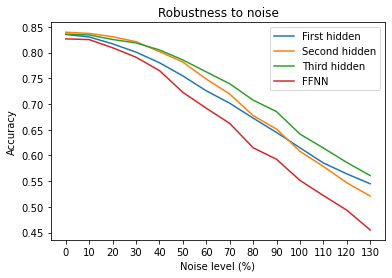

In [42]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

# Adversarial attacks

Adversarial attacks refer to the process of intentionally peturbing input data in a way that causes a network to missclassify it. One common type of adversarial attack is the Fast Gradient method. Shortly, this attack involves taking the gradient of the loss with respect to the input and then perturbing the input by a small amount in the direction of the sign of the gradient.

In [43]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad #epsilon, strenght of the attack

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [49]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_fashion, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_fashion = dbn_fashion
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
        for rbm in self.dbn_fashion.rbm_layers:
            rbm.W.requires_grad_()
            rbm.h_bias.requires_grad_()

    def forward(self, image):
        p_v = image
        hidden_states = []
    
        for rbm in self.dbn_fashion.rbm_layers:
            p_v = p_v.view((p_v.shape[0], -1))  # flatten
            p_v, v = rbm(p_v)
            hidden_states.append(p_v)
        return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [50]:
# target is the top level of network

dbn_with_readout = DBNWithReadOut(dbn_fashion, [linear1, linear2, linear3], readout_level=2)

This is how an adversiarial sample looks like:

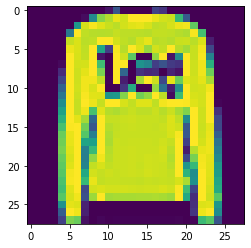

In [52]:
test_sample_idx = 1
test_image = fashion_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

We will classify this example using the models trained previously and then we will use the noisy image as input to our models to see how they will classify it.

In [53]:
# start with feed-forward

attacked_model = ffnn
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {fashion_train.classes[prediction]}.")


The prediction of the model for this clean sample is Pullover.


In [54]:
# go on with DBN

attacked_model = dbn_with_readout
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {fashion_train.classes[prediction]}.")

The prediction of the model for this clean sample is Pullover.


Let's create and visualize the corresponding adversarial sample. The function loss.backward() computes the gradient for every parameter that was activated using the call requires_grad=True.

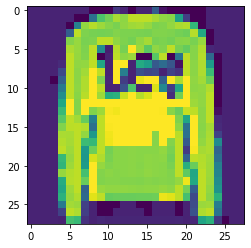

In [55]:
epsilon = 0.1  # define strenght of the attack
test_image_label = fashion_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [56]:
# output of noisy image feed-forward

attacked_model = ffnn
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 2.


In [57]:
# output of noisy image DBN
attacked_model = dbn_with_readout
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 2.


If we compare Gaussian Noise with Adversarial Attacks, we can say that the noise added by the first method makes the image impossible to recognize for humans, the network perfectly identifies the image. The oposite happens on the second approach.

# Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [66]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
  #num steps: how many top down reconstruction steps we want to perform with the DBN
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
            print("\nHere's the original sample:\n")
            plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_fashion.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [67]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [68]:
# how good ffnn does

final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 25.93%



In [69]:
# Let's now compare compare with the read-out trained on the hidden representations of the DBN:

final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 40.72%



Let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



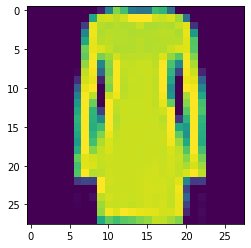


Here's a perturbed sample:



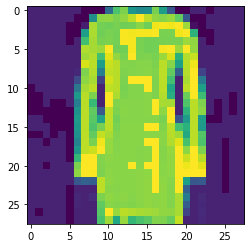


Here's what a 1-steps reconstructed sample looks like:



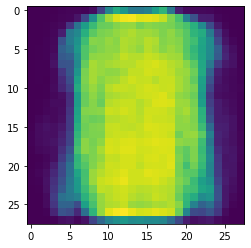


Epsilon: 0.1
Test Accuracy: 38.71%



In [70]:


final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

We can say that the generative model can't reconstruct the data anymore, depending on the noise parameter and the number of steps.

# Effect of the noise parameter ϵ

In [71]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
    accuracies = list()

    for eps in epsilon_values:
        acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
        accuracies.append(acc)

    return accuracies

In [72]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

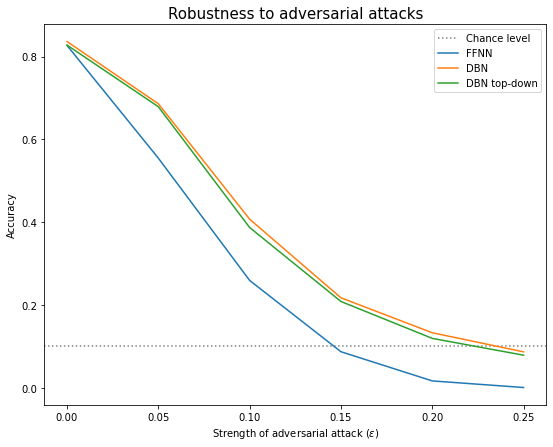

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

Looking at the plot, we see that the performance of feed-forward NN drops quickly. Both DBN networks (the first form and the one with one construction step) have almost the same shape and behavior. The accuracy drops by less than 50% with a strength between 0.05 and 0.1. Concluding, DBN performs better than FFNN even for different strengths of attack. 

If we compare the results obtained by Fashion MNIST with MNIST used during labs, we can say that the model is performing worse in terms of performance against noise in data, probably because the classes of dataset explored in this notebook are more complex than the numbers.

To mitigate the vulnerability against adversarial attacks or random noise we can follow some approaches as:
     1. Adversarial training: the model is trained on both clean and adversarial samples to improve its robustness against    attacks.
     2. Input preprocessing: Applying preprocessing techniques, such as input normalization or adding noise to the input data, can help reduce the model's sensitivity to adversarial perturbations.
     3. Create "Deep Fakes", generate fake but very realistic images based on deep generative learning
     

# Appendix

I'm adding the results obtained by using another structure of DBN. Using as contrastive divergence 5 and learning rate 0.5. Is quite intersting how reconstruction errors drops quickly moving forward from the first to the last hidden layer. As for now, looks like it is performing better than the architecture presented during labs and in this project.

In [79]:
%%html
<iframe src="https://drive.google.com/file/d/1Dimnou8GGlO8zUe9vYWdQBzYheZJdIuK/preview" width="800" height="200" allow="autoplay"></iframe>

In [80]:
%%html
<iframe src="https://drive.google.com/file/d/1BHUFnP3GJ4KCMvwMvBAXc61GJFCnC8xe/preview" width="800" height="400" allow="autoplay"></iframe>

Training the model and looking at the loss after each epoch, we obtain higher loss compared with the proposed architecture.

In [87]:
%%html
<iframe src="https://drive.google.com/file/d/1aWxwa8ZEifGUaq-UHnSslxD1rwGzZhlV/preview" width="600" height="400" allow="autoplay"></iframe>

In [86]:
%%html
<iframe src="https://drive.google.com/file/d/16v7K4mK_up2qxnblpSehw7YgL95ekq4O/preview" width="600" height="400" allow="autoplay"></iframe>

In [85]:
%%html
<iframe src="https://drive.google.com/file/d/16RFt6Cm9jvXEtmkvN4SCbXr8PStq7U_i/preview" width="600" height="400" allow="autoplay"></iframe>

Indeed, as expected, accuracy gets worse.

In [92]:
%%html
<iframe src="https://drive.google.com/file/d/1QHnqbiXViUTIdvvwjLh4mcfx_E1ZZwwR/preview" width="800" height="100" allow="autoplay"></iframe>